## KAGGLE HOUSE PRICE PREDICTION
- Predict sales prices and practice feature engineering
- The aim of this competition is to predict the house prices using machine learning regression techniques, based on the various informations provided about the houses in the dataset provided.


Importing libraries

In [1]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#modelling
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb


**DATA PRE-PROCESSING**

In [2]:
#Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

FileNotFoundError: File b'train.csv' does not exist

Examining the data to inspect all the elements that are present

In [3]:
train.head()

NameError: name 'train' is not defined

Start with Pre-processing by saving the ID column to be used in the submission and dropping it from the dataset, because it contains no significance to the data other than to place a unique integer to identifier to each row of data.

In [4]:
#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#drop the  'Id' column
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#checking outliers via a scatter plot
plt.rcParams['figure.figsize']=(10,6)
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'],color='green')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('Outlier Checking',fontsize=20)
plt.show()


NameError: name 'train' is not defined

<font color=red>NB! Outliers will be dealt with under feature engineering</font><br/>

Analysis of the target variable (SalePrice)



In [5]:
#Draw a Histogram to see the distribution of the SalePrice
plt.rcParams['figure.figsize']=(10,6)
print ("The skewness is:", train.SalePrice.skew())
sns.distplot(train['SalePrice'], fit = norm,color='orange');
plt.ylabel('Frequency')
plt.title('SalePrice Distribution',fontsize=20)
plt.show()

NameError: name 'train' is not defined

- From the histogram plot we can see that the target variable is right skewed, this voilates the assumption of linear model, which is data must be normally distributed.
- To handle this we log transform the target variable to make it follow a normal distribution, as seen in the histogram below. 

In [6]:
#log tranform to fix target skewness and check distribution again
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'] , fit=norm ,color='green');
plt.ylabel('Frequency')
plt.title('SalePrice distribution',fontsize=20)
plt.show()
print ("Skewness is:", train.SalePrice.skew())

NameError: name 'train' is not defined

_**A value closer to 0 (0.121...) in this case means we have imrpoved the skewness of the data and thus we have now successfully obtained a normal distribution.**_

**FEATURE ENGINEERING**

Outliers

- From the documetation recieved with the data,it indicates that there are outliers present in the training data which were recommended to be removed.
- Though removing outliers is not always a safe option to take, as it can have a bad affect on our model.

In [7]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

NameError: name 'train' is not defined

NameError: name 'train' is not defined

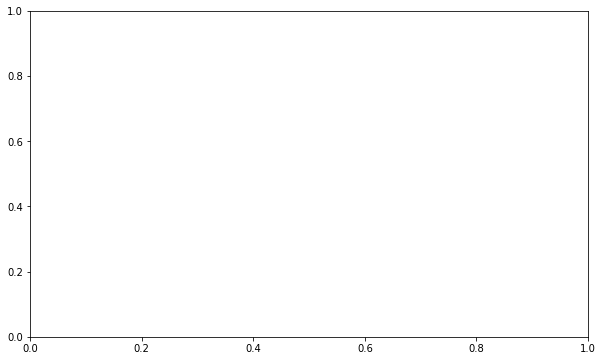

In [8]:
#checking outliers via a scatter plot after deleting of outliers
plt.rcParams['figure.figsize']=(10,6)
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'],color='green')
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('Outlier Checking After Deletion',fontsize=20)
plt.show()

Join the train and test data into the same dataframe

In [9]:
#FEATURES ENGINEERING
y_train = train.SalePrice.values

#combine the data
new_train = train.shape[0]
new_test = test.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

NameError: name 'train' is not defined

Correlation map

- Correlation map showing relationship between all variables
- Analysing correlation map allows visualization of the significance and relationshiip other variables have on the target variable

In [10]:
#Correlation map to see relationship between features and SalePrice
corrmat = train.corr().sort_values(by=['SalePrice'],ascending=False)
print('\033[1m'+'Correlation Heatmap:'+'\033[0m')
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.9,square=True,linewidths=0.9,cmap='viridis')

NameError: name 'train' is not defined

- List of correlation values of other features with SalePrice

In [11]:
#correlation with SalePrice
print('\033[1m'+'Correlation Values:'+'\033[0m')
print (corrmat['SalePrice'].sort_values(ascending=False)[:])

Correlation Values:


NameError: name 'corrmat' is not defined

Missing Values
- A list of the percentages of missing data within each column

In [12]:
#percentage of missing data in all data

length = len(all_data)
all_dataNA = (all_data.isnull().sum() / length) * 100
all_dataNA = all_dataNA.drop(all_dataNA[all_dataNA == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_dataNA})
missing_data.head(20)

NameError: name 'all_data' is not defined

- We fix some feature with high percentage of missing values, proceeding from one feature to the next
- There are some features were NaN is considered as absence of such property instead of no data,therfore we replace it with 0 or 'None'. In other cases I replace NaN with the median or mode.

In [13]:
#fixing some feature with high percentage of missing values
all_data["PoolQC"] = all_data["PoolQC"].fillna("None") #NA means no pool thus replace with none
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")


#fill in missing values by median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))#grouped lot by neighborhood

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)#No garage means no cars
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)#drop wont help in the model

all_data["Functional"] = all_data["Functional"].fillna("Typ")#NA means typical

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0]) #replace NA with most common

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0]) #replace NA with most common

#replace NA with most common
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

NameError: name 'all_data' is not defined

- Transforming some numerical variables that are categorical

In [14]:
#Tranforming some categorical numeric variables

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

NameError: name 'all_data' is not defined

- Label Encoding some categorical variables

In [15]:
# Apply LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for col in cols:
    label = LabelEncoder() 
    label.fit(list(all_data[col].values)) 
    all_data[col] = label.transform(list(all_data[col].values))

NameError: name 'all_data' is not defined

- Aggregate the total area of basement, first and second floor areas of each house.

In [16]:
#add feature which is total of basement, 1st and 2nd floor
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

NameError: name 'all_data' is not defined

In [17]:
all_data

NameError: name 'all_data' is not defined

Skewness of numerical feature

- List the numerical features and their skewness

In [18]:
#skewness of all numerical features
numeric_features = all_data.dtypes[all_data.dtypes != "object"].index
skewed_features = all_data[numeric_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewness' :skewed_features})
skewness.head(10)


NameError: name 'all_data' is not defined

- Fix the skewness of the features using box-cox transform function

In [19]:
#attemp to use boxcox1p function for skewed features
#Computes the Box-Cox transformation of 1 + x.
#https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

skewed_features = skewness.index
lmbda = 0.15
for feature in skewed_features:
    all_data[feature] = boxcox1p(all_data[feature], lmbda)

NameError: name 'skewness' is not defined

- Get dummy categorical variable from combined data

In [20]:
#get dummy categorical variable from the combined data

all_data = pd.get_dummies(all_data)
train = all_data[:new_train]
test = all_data[new_train:]

NameError: name 'all_data' is not defined

**MODELLING**

Using different regression models to get the lowest root mean square error on the target variable, this would result in the most accurate prediction.

In [21]:
#Models

#cross Validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [22]:
#LASSO
#model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train, y_train)
#y_pred = model_lasso.predict(test)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state =1))
lasso.fit(train,y_train)
y_pred = lasso.predict(test)
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: name 'train' is not defined

In [23]:
#XGBOOST

xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
xgb.fit(train,y_train)
y_pred2 = xgb.predict(test)
score = rmsle_cv(xgb)
print("\nXgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: name 'train' is not defined

In [24]:
#make prediction on the test set
Final_label = (np.exp(y_pred))
sub = pd.DataFrame({'Id': test_ID, 'SalePrice': Final_label})
sub.to_csv('submission2.csv', index =False) 

NameError: name 'y_pred' is not defined